<a href="https://colab.research.google.com/github/HeqingZ/FCOStry/blob/main/FCOS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!python -m pip install pyyaml==5.1
!python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

In [2]:
#import some important utilitie sof detectron2
import torch, detectron2
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
cuda_langar_version = torch.__version__.split('+')[-1]
print("torch: ", TORCH_VERSION, "cuda: ", cuda_langar_version)
print("detectron2: ", detectron2.__version__)

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Mon_Oct_12_20:09:46_PDT_2020
Cuda compilation tools, release 11.1, V11.1.105
Build cuda_11.1.TC455_06.29190527_0
torch:  1.12 cuda:  cu113
detectron2:  0.6


In [3]:
#some basic setup 
#setupd detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

#import some common libraries
import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow

#import some common detectron2 utilities 
#important update Aug 19: Please open poolers.py, and comment out lines 10, 223 - 237
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
#import features for bbox
import numpy as np
import matplotlib.pyplot as plt

from detectron2.structures import BoxMode

Dataloader :))

In [4]:
#define the file path to retrieve images
def FLIR(source_path, img_dir, anno_dir ): #define a function. assuming user doesnt know shit about coding and enter random stuff. related to anno dir and img dir
    img_dir = os.path.join(source_path, img_dir)
    anno_dir = os.path.join(source_path, anno_dir)
    data_dicts = []
    #define annotation properties
    with open(anno_dir) as F:
      jsonfile = json.load(F) #load annotations from json file into the dictionary
    
    annotationinfo = jsonfile["annotations"]
    imagesinfo = jsonfile["images"] #retreieve info like category ID and bbox
   
    #define img sources
     
    img_dir_list = os.listdir(img_dir)#get the list of all files and directories in the specified directory.
    # print(img_dir)
    for img_info in imagesinfo: #bbox info category id
      for images in img_dir_list:  #img_dir_list = img_dir, which is source_path/img_dir(original)
        images = "data/" + images
        if images == img_info['file_name']: #see if name matches each other, because we wanna find the filenames only for the small flir out of the whole json file

          record={}
          filename = os.path.join(source_path, img_info["file_name"])
          # print(filename)
          record["file_name"] = filename
          record["image_id"] = img_info['id']
          record["height"] = img_info['height']
          record['width'] = img_info['width']
        
          box_info = []
          
          for anno in annotationinfo:
            if anno["image_id"] == img_info['id']:
              # if (anno['category_id'] <= 3) & (anno['category_id'] > 0):
              if (anno['category_id'] == 1) & (anno['category_id'] > 0): # Predict people only
                        box = {
                        "bbox": anno['bbox'],
                        'bbox_mode': BoxMode.XYWH_ABS, # Category_id starts from 0 in detectron2
                        'category_id': int(anno['category_id']-1)  #we forcibly convert this shit into integer to be able to minus 1. just incase the stuff from the dict is integer
                        #computer counts from zero but not hyman. we have to substract one to match the computer #update Jun29: i deleted -1, bcz there is no category 0 
                        } #exactly how dictionary looks like
                        imagetesthaha = cv2.imread(filename, 0) 
                        tt = cv2.rectangle(imagetesthaha, anno["bbox"], (255,0,0),2)
                        #cv2_imshow(tt) #for printing all boxes in images one by one, will crash
                        box_info.append(box)
          record["annotations"] = box_info

          data_dicts.append(record)
    return data_dicts

      
      
    #print(type(jsonfile)) #check the  type of jsonfile. dict or list or stuff



#define dataloader for training and testing sets
#train_dataloader = dataloader(training_data, batch_size=64, shuffle=True)
#test_dataloader = dataloader(test_data, batch_size=64, shuffle=True)


In [ ]:
DatasetCatalog.clear()# unregister stuff in case hit register twice lol

In [5]:
for d in ['train', 'val']:
  DatasetCatalog.register("FLIR_THERMAL_" + d + "_data", lambda d=d: FLIR("/content/drive/MyDrive/FLIR_THERMAL/train", "data", "coco.json")) #changed "/directry/stuff/" +d +"shit" into this rn
  MetadataCatalog.get("FLIR_THERMAL_" + d + "_data").set(thing_classes=["FLIR_THERMAL"])
FLIR_metadata = MetadataCatalog.get("FLIR_THERMAL_train_data")

In [6]:
#to varify our thing by calling the function
dataset_dicts = FLIR("/content/drive/MyDrive/FLIR_THERMAL/train", "data", "coco.json")


In [ ]:
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [ ]:
torch.cuda.empty_cache

<function torch.cuda.memory.empty_cache() -> None>

Train

In [7]:
!pip3 install --upgrade pip


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.0 MB 14.5 MB/s 
  Attempting uninstall: pip
    Found existing installation: pip 21.1.3
    Uninstalling pip-21.1.3:
      Successfully uninstalled pip-21.1.3


In [8]:
!pip install fcos


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 152.8/152.8 kB 9.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for fcos: filename=fcos-0.9.8-cp37-cp37m-linux_x86_64.whl size=2796929 sha256=50182df70db464d96127f054072b267b7b41e920908dd05a1e030cbf1a1cbbc0
  Stored in directory: /root/.cache/pip/wheels/a6/14/ec/911ce7084df67b170fa4ea3fa6312381f3f60eae5af41d05ad
  Created wheel for pycocotools: filename=pycocotools-2.0.1-cp37-cp37m-linux_x86_64.whl size=265255 sha256=ee7d1baec3c50d3dc09acde07e000fed1e0db875897f536c97c83e79cba58603
  Stored in directory: /root/.cache/pip/wheels/12/36/32/2bae0d429403617ca371aa0a08b16f8746a09a5f56a3ae5ce1
Successfully built fcos pycocotools
  Attempting uninstall: pycocotools
    Found existing installa

In [ ]:
from detectron2.engine import DefaultTrainer

cfg = get_cfg()
!/content/drive/MyDrive/fcos.py --cfg configs/fcos DATA.PATH_TO_DATA_DIR "/content/drive/MyDrive/FLIR_THERMAL/train" --num-gpus 8 #tools fcos.py 还是 tools/main.py

cfg.DATASETS.TRAIN = ("FLIR_THERMAL_train_data",)
# cfg.MODEL.RESNETS.DEPTH = 50 #for mvit v2 S we are setting the depth = 101. (F)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.SOLVER.IMS_PER_BATCH = 4  # This is the real "batch size" commonly known to deep learning people 'changed to 5'
cfg.SOLVER.BASE_LR = 0.01 #SET ALL TO 0.0001
cfg.SOLVER.MAX_ITER = 90000    # 270000 for 3x (F)
cfg.SOLVER.STEPS = []        # do not decay learning rate
cfg.SOLVER.WARMUP_FACTOR = 1.0 / 10000
cfg.SOLVER.WARMUP_ITERS = 10000
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 512   # chose 512 for 3x
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # only has one class (people). (see https://detectron2.readthedocs.io/tutorials/datasets.html#update-the-config-for-new-datasets)
# NOTE: this config means the number of classes, but a few popular unofficial tutorials incorrect uses num_classes+1 here.
cfg.MODEL.MASK_ON = False
# cfg.MODEL.RESNETS.DEFORM_MODULATED = True
cfg.MODEL.BACKBONE.FREEZE_AT = 0
cfg.OUTPUT_DIR = '/content/drive/MyDrive/FCOStry'


os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=True)
trainer.train()

/bin/bash: /content/drive/MyDrive/fcos.py: Permission denied
[08/22 08:29:17 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): ResNet(
    (stem): BasicStem(
      (conv1): Conv2d(
        3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
        (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
      )
    )
    (res2): Sequential(
      (0): BottleneckBlock(
        (shortcut): Conv2d(
          64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=256, eps=1e-05)
        )
        (conv1): Conv2d(
          64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
        (conv2): Conv2d(
          64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
        (conv3): Conv2d(
          64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False
     

/usr/local/lib/python3.7/dist-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2894.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[08/22 08:41:23 d2.utils.events]:  eta: 19:29:36  iter: 45019  total_loss: 0.1908  loss_cls: 0.04719  loss_box_reg: 0.117  loss_rpn_cls: 0.006132  loss_rpn_loc: 0.01648  time: 1.5605  data_time: 0.0349  lr: 0.01  max_mem: 9391M
[08/22 08:41:55 d2.utils.events]:  eta: 19:31:38  iter: 45039  total_loss: 0.1836  loss_cls: 0.04225  loss_box_reg: 0.1202  loss_rpn_cls: 0.005069  loss_rpn_loc: 0.01289  time: 1.5647  data_time: 0.0241  lr: 0.01  max_mem: 9391M
[08/22 08:42:26 d2.utils.events]:  eta: 19:34:19  iter: 45059  total_loss: 0.2001  loss_cls: 0.05188  loss_box_reg: 0.1294  loss_rpn_cls: 0.006473  loss_rpn_loc: 0.0127  time: 1.5703  data_time: 0.0231  lr: 0.01  max_mem: 9391M
[08/22 08:42:58 d2.utils.events]:  eta: 19:38:07  iter: 45079  total_loss: 0.1979  loss_cls: 0.04883  loss_box_reg: 0.1253  loss_rpn_cls: 0.009307  loss_rpn_loc: 0.01325  time: 1.5740  data_time: 0.0212  lr: 0.01  max_mem: 9391M
[08/22 08:43:30 d2.utils.events]:  eta: 19:42:22  iter: 45099  total_loss: 0.1925  los

LR warmed back up to 0.01 at between 9999 and 10019

In [10]:
from detectron2.utils.visualizer import ColorMode

#Use the final weights generated after successful training for inference  
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")

cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # ALL THRESHOLD = 0.5
#Pass the validation dataset
cfg.DATASETS.TEST = ("boardetect_val", )

predictor = DefaultPredictor(cfg)

[08/23 05:55:16 d2.checkpoint.c2_model_loading]: Following weights matched with model:
| Names in Model                                  | Names in Checkpoint                                                                         | Shapes                                          |
|:------------------------------------------------|:--------------------------------------------------------------------------------------------|:------------------------------------------------|
| backbone.res2.0.conv1.*                         | backbone.res2.0.conv1.{norm.bias,norm.running_mean,norm.running_var,norm.weight,weight}     | (64,) (64,) (64,) (64,) (64,64,1,1)             |
| backbone.res2.0.conv2.*                         | backbone.res2.0.conv2.{norm.bias,norm.running_mean,norm.running_var,norm.weight,weight}     | (64,) (64,) (64,) (64,) (64,64,3,3)             |
| backbone.res2.0.conv3.*                         | backbone.res2.0.conv3.{norm.bias,norm.running_mean,norm.running_var,norm.weig

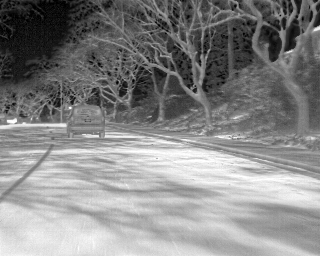

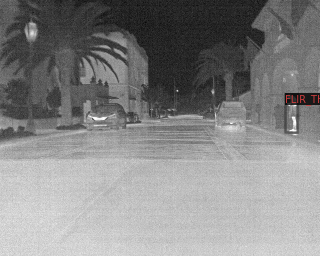

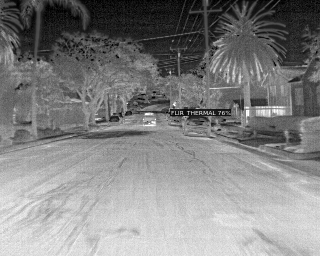

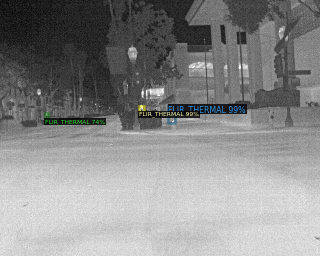

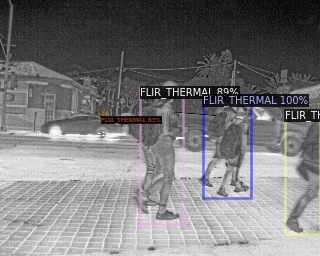

In [14]:
#see if this shit is wroking aka run instance on test images
from detectron2.utils.visualizer import ColorMode
dataset_dicts = FLIR("/content/drive/MyDrive/FLIR_THERMAL/val/", "data", "coco.json")
for d in random.sample(dataset_dicts, 5):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
    v = Visualizer(im[:, :, ::-1],
                   metadata=FLIR_metadata, 
                   scale=0.5, 
                      # remove the colors of unsegmented pixels. This option is only available for segmentation models
    )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(out.get_image()[:, :, ::-1])

In [15]:
from detectron2.data import DatasetCatalog, MetadataCatalog, build_detection_test_loader
from detectron2.evaluation import COCOEvaluator, inference_on_dataset

cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5 #ALL THRESHOLD = 0.5 
predictor = DefaultPredictor(cfg)
evaluator = COCOEvaluator("FLIR_THERMAL_train_data", cfg, False, output_dir="content/output/")
val_loader = build_detection_test_loader(cfg, "FLIR_THERMAL_val_data")
inference_on_dataset(trainer.model, val_loader, evaluator)

[08/23 05:56:50 d2.checkpoint.c2_model_loading]: Following weights matched with model:
| Names in Model                                  | Names in Checkpoint                                                                         | Shapes                                          |
|:------------------------------------------------|:--------------------------------------------------------------------------------------------|:------------------------------------------------|
| backbone.res2.0.conv1.*                         | backbone.res2.0.conv1.{norm.bias,norm.running_mean,norm.running_var,norm.weight,weight}     | (64,) (64,) (64,) (64,) (64,64,1,1)             |
| backbone.res2.0.conv2.*                         | backbone.res2.0.conv2.{norm.bias,norm.running_mean,norm.running_var,norm.weight,weight}     | (64,) (64,) (64,) (64,) (64,64,3,3)             |
| backbone.res2.0.conv3.*                         | backbone.res2.0.conv3.{norm.bias,norm.running_mean,norm.running_var,norm.weig

OrderedDict([('bbox',
              {'AP': 43.61094063668531,
               'AP50': 77.21294260173028,
               'AP75': 44.658900951195726,
               'APs': 37.04131095567992,
               'APm': 67.2040224172126,
               'APl': 63.53968554959572})])